# PracApp3: Comparing Classifiers

In this practical application, I compare the performance of 6 classifiers: [] on a dataset for marketing bank products over the telephone. 

Dataset [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing). The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns. [Article](CRISP-DM-BANK.pdf) for more info on data and features.

The primary goal of this application is to produce a model which performs well in predicting the characteristics of bank customers which are most likely to be converted. In this way, a bank ideally would target resources more efficiently to improve return-on-investment for man-hours telemarketing and reduce the sense of intrusion experienced by costumers who are unlikely to be interested in the product.

This analysis follows the CRISP-DM methodology by beginning first with a breakdown and understanding of the dataset, including preprocessing (mapping, one-hot encoding) of features. I begin by fitting a dummy classifier to define a baseline accuracy. I attempt feature reduction using elasticnet and PCA as part of data understanding, however the results are not strong enough to propagate further in the analysis. I then fit the dataset using all 6 aforementioned models and compare their performance. In my case, the Decision Tree Classifier performs best. I fine-tune the model to an accuracy which improves the baseline by 41%. I assess the performance of the model using the Lift curve metric.

This data is of 17 Portuguese direct-marketing campaigns for bank deposition subscription. 

The data is split into two groups: bank client, campaign, outcomes and socioeconomic attributes.

Client:
- 1 - age (numeric)
- 2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- 3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- 4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- 5 - default: has credit in default? (categorical: 'no','yes','unknown')
- 6 - housing: has housing loan? (categorical: 'no','yes','unknown')
- 7 - loan: has personal loan? (categorical: 'no','yes','unknown')

Related with the last contact of the current campaign:
- 8 - contact: contact communication type (categorical: 'cellular','telephone')
- 9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- 10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- 11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Outcomes:
- 12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- 13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- 14 - previous: number of contacts performed before this campaign and for this client (numeric)
- 15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Socioeconomic:
- 16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
- 17 - cons.price.idx: consumer price index - monthly indicator (numeric)
- 18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- 19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
- 20 - nr.employed: number of employees - quarterly indicator (numeric)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [12]:
df = pd.read_csv('./data/bank-additional-full.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The dataset has 41,118 entries and is not missing any values.

Let's analyze the individual columns.
1. `age, duration, campaign, ndays, previous, emp.var.rate, cons.price.idx, cons.conf.indx, euribor3m, nr.employed` are numeric sequential values.
2. `default, housing, loan` are labelled with strings but are binary.
3. `month, day_of_week` are labelled numeric sequential
4. `job, marital, education, contact, poutcome` are nonsequential nonbinary labels. They will need to be one-hot encoded.
5. `y` is in yes/no binary strings.

Let's map the values in 3. and 5. to the appropriate numeric value (map strings to appropriate number). We can then create a transformer for the values in 2. and 4. to be one-hot encoded, making special note to include `drop='if_binary'` to avoid autocorrelated features for columns in 2.

Lastly, let's apply a standard scaling to avoid biasing high-value columns. This dataset is then ready to be split into training and test datasets.

In [13]:
# Map months and days of the week
df['month'] = df['month'].map({mt:i for i,mt in enumerate(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])})
df['day_of_week'] = df['day_of_week'].map({d:i for i,d in enumerate(['mon', 'tue', 'wed', 'thu', 'fri'])})

# Remap labels appropriately.
df['y'] = df['y'].map({'yes':1, 'no':0})

# Make a one-hot encoder transformer
tfm = make_column_transformer((\
    (OneHotEncoder(drop = 'if_binary'),['job', 'marital', 'education', 'contact', 'poutcome', 'default', 'housing', 'loan'])
    ), remainder='passthrough')

# Apply transformation
X = StandardScaler().fit_transform(tfm.fit_transform(df.drop('y', axis=1)))
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

Let's first perform a dummy classification to determine the baseline performance of a random classifier.

Clearly, there are far more 'no' than 'yes' -- 88.7% of customers are not converted.

In [30]:
# Check performance with a dummy classifier

model = DummyClassifier().fit(X_train, y_train)

print('Default rate: no/(yes+no) %.3f'%(df['y'].value_counts()[0]/df['y'].value_counts().sum()))

pd.DataFrame({
    'Name': ['Dummy Classifier'],
    'train_score': [model.score(X_train, y_train)],
    'test_score': [model.score(X_test, y_test)]
})

Default rate: no/(yes+no) 0.887


,Name,train_score,test_score
0,Dummy Classifier,0.887309,0.887432


This section has become an aside; I attempted to perform some feature selection to decrease the computation time of certain models -- such as the rbf and poly SVCs.

I did this first with the SGDClassifier. I chose to use elasticnet (L1 + L2) to impose a balanced regularization on the features. I sampled a loss surface with the regularization strength and picked the best-performing classifier. This resulted in just 15 non-zero features. When applying this reduction to the dataset, however, downline model performance was affected to an order of roughly 10%.

Next, I attempted to reduce the dimensionality of the dataset by retaining just 90% of the feature variance. Again, this reduction affected model performance poorly.

As a result, I decided simply to run the subsequent for subsequently smaller sampling ranges, manually.

Text(0.5, 1.0, 'Tuning of regularization strength for Logistic Regression')

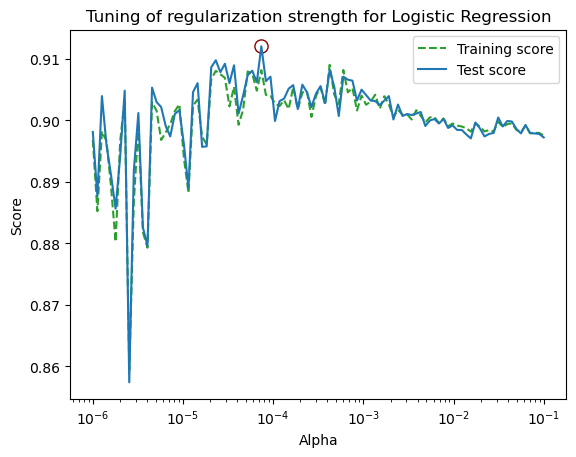

In [35]:
# Feature selection

alphas = np.logspace(-6,-1,100)

scores = {'train':[],'test':[]}
for alpha in alphas:
    model = SGDClassifier(penalty = 'elasticnet', alpha = alpha)
    model.fit(X_train, y_train)
    scores['train'].append( model.score(X_train, y_train) )
    scores['test'].append( model.score(X_test, y_test) )
    if False: print('Alpha %e'%alpha);

plt.plot(alphas, scores['train'], label = 'Training score', linestyle='--', color = 'C2')
plt.plot(alphas, scores['test'], label = 'Test score', linestyle='-', color = 'C0')
plt.scatter(alphas[scores['test'].index(max(scores['test']))], max(scores['test']), facecolor = 'white', edgecolor = 'darkred', s = 90, zorder=-1)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.xscale('log')
plt.legend()
plt.title('Tuning of regularization strength for Logistic Regression')

In [41]:
model = SGDClassifier(penalty='elasticnet', alpha = alphas[scores['test'].index(max(scores['test']))])
model.fit(X_train, y_train)

print(tfm.get_feature_names_out()[np.where(np.array(model.coef_) != 0.)[1]])

# reduced_X_train = X_train[:,np.where(np.array(model.coef_) != 0.)[1]]
# reduced_X_test = X_test[:,np.where(np.array(model.coef_) != 0.)[1]]

['onehotencoder__job_admin.' 'onehotencoder__education_basic.9y'
 'onehotencoder__contact_telephone' 'onehotencoder__poutcome_failure'
 'onehotencoder__poutcome_success' 'onehotencoder__default_no'
 'onehotencoder__default_unknown' 'onehotencoder__default_yes'
 'remainder__month' 'remainder__duration' 'remainder__pdays'
 'remainder__emp.var.rate' 'remainder__cons.price.idx'
 'remainder__euribor3m' 'remainder__nr.employed']


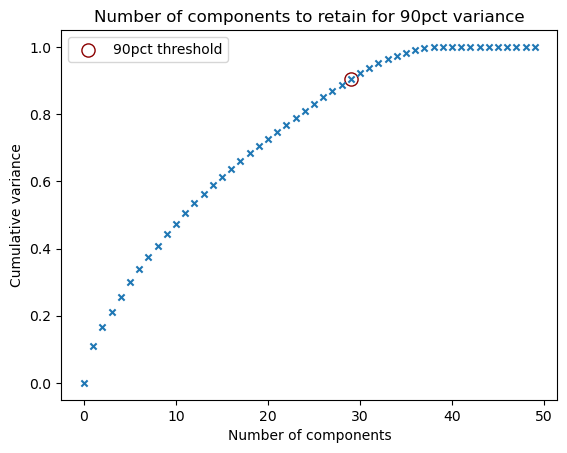

In [32]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full')
pca.fit(X_train, y_train)

cumsum = [0.]
for val in pca.explained_variance_ratio_:
    cumsum.append(cumsum[-1] + val)

plt.scatter(range(len(cumsum)),cumsum, s=20, marker = 'x')
# plt.axhline(.9, label = '80pct threshold', color = 'C1', linestyle='--')
comp = np.where(np.array(cumsum) >= .9)[0][0]
plt.scatter(comp, cumsum[comp],s=90, edgecolors='darkred', facecolors = 'white', zorder= -1, label = '90pct threshold')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance')
plt.legend()
plt.title('Number of components to retain for 90pct variance')


pca = PCA(svd_solver= 'full', n_components = comp)
pca.fit(X_train, y_train)
# reduced_X_train = pca.transform(X_train)
# reduced_X_test = pca.transform(X_test)

I compared the performance of 6 models: Logistic Regression, Decision Tree, SVC-linear kernel, SVC-rbf kernel, K Neighbors and SGD Classifier. I also tested SVC-polynomial kernel, however its performance was no better than other classifiers, and its fit-time was significantly poorer.

My selection process for the parameter space was to first sweep a area with low-samples (i.e. 10 fits across 10 orders of magnitudes) and to slowly converge towards the best-performing range and producing a fit over a range of roughly 100 samples. This step was taken because the fit time of certain models (especially SVC) was far too long. As discussed above, feature reduction negatively impacted the performance of some models. As a result, this approach was chosen instead.

In [35]:
model_names = {'lr':LogisticRegression(), 'dt':DecisionTreeClassifier(), 'svc-lin':SVC(), 'svc-rbf':SVC(), 'knn':KNeighborsClassifier(), 'sgd':SGDClassifier()}#, 'svp':SVC()}

param_grid = {}
param_grid['knn'] = {'n_neighbors':np.arange(1,30)}
param_grid['lr'] = {'max_iter':np.logspace(2,4, 100)}
param_grid['dt'] = {'max_depth':np.logspace(0,4,100)}
param_grid['svc-lin'] = {'kernel':['linear'], 'gamma': np.logspace(-3,3,30)}
param_grid['svc-rbf'] = {'kernel':['rbf'], 'gamma': np.logspace(-3,0,20)}
param_grid['sgd'] = {'penalty':['elasticnet'], 'alpha':np.logspace(-6,-1,100)}
# param_grid['svp'] = {'kernel':['poly'], 'degree':np.arange(2,4), 'gamma':np.logspace(-5,5,N)}

results = {'name':[], 'best_estimator':[], 'train_score':[], 'test_score':[], 'avg_fit_time':[]}

for name in model_names:

    print('Working on %s'%name)

    model = model_names[name]
    
    search = GridSearchCV(estimator=model, param_grid = param_grid[name], verbose=3, cv=2)

    search.fit(X_train, y_train)

    results['name'].append(name)
    results['best_estimator'].append(search.best_estimator_)
    results['train_score'].append(search.best_estimator_.score(X_train, y_train))
    results['test_score'].append(search.best_estimator_.score(X_test, y_test))
    results['avg_fit_time'].append(search.cv_results_['mean_fit_time'].mean())
    
    print('Completed. \n')

Working on lr
Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 1/2] END ....................max_iter=100.0;, score=0.908 total time=   0.5s
[CV 2/2] END ....................max_iter=100.0;, score=0.911 total time=   0.5s
[CV 1/2] END .......max_iter=104.76157527896652;, score=0.908 total time=   0.3s
[CV 2/2] END .......max_iter=104.76157527896652;, score=0.911 total time=   0.4s
[CV 1/2] END .......max_iter=109.74987654930557;, score=0.908 total time=   0.2s
[CV 2/2] END .......max_iter=109.74987654930557;, score=0.911 total time=   0.3s
[CV 1/2] END .......max_iter=114.97569953977356;, score=0.908 total time=   0.9s
[CV 2/2] END .......max_iter=114.97569953977356;, score=0.911 total time=   0.1s
[CV 1/2] END .......max_iter=120.45035402587824;, score=0.908 total time=   0.1s
[CV 2/2] END .......max_iter=120.45035402587824;, score=0.911 total time=   0.1s
[CV 1/2] END ........max_iter=126.1856883066021;, score=0.908 total time=   0.2s
[CV 2/2] END ........max_iter=12

In [53]:
df = pd.DataFrame(results)
df['Test score improvement over dummy classifier (pct)'] = ((df['test_score'] - 0.887432)/(1-df['test_score']) * 100)
df

,name,best_estimator,train_score,test_score,avg_fit_time,Test score improvement over dummy classifier (pct)
0,lr,LogisticRegression(max_iter=100.0),0.910478,0.910011,0.217119,25.090178
1,dt,DecisionTreeClassifier(max_depth=4.03701725859...,0.913322,0.915271,0.105688,32.856044
2,svc-lin,"SVC(gamma=0.001, kernel='linear')",0.902223,0.901837,11.214238,14.674590
3,svc-rbf,SVC(gamma=0.018329807108324356),0.919115,0.906126,18.861872,19.914032
4,knn,KNeighborsClassifier(n_neighbors=23),0.902778,0.898276,0.005499,10.660523
5,sgd,"SGDClassifier(alpha=0.00010476157527896651, pe...",0.906802,0.905317,0.275390,18.889126


Evidently, the Logistic Regression and Decision Tree perform better than most other models. Let's take the Decision Tree and continue fine-tuning the model.

Fitting 2 folds for each of 200 candidates, totalling 400 fits


Text(0.5, 1.0, 'Hyperparameter tuning of Decision Tree Classifier max_depth')

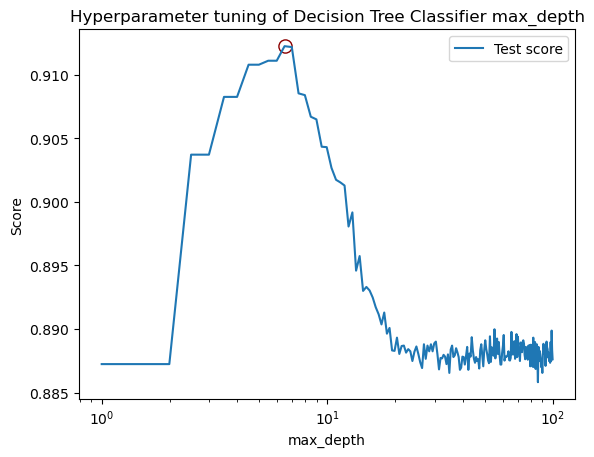

In [34]:
fig, ax = plt.subplots()#1,2,figsize=(12,8))

# param_grid['lr'] = {'max_iter':np.logspace(1,3, 100)}
dtree_param = {'max_depth':np.linspace(1,100,200)}


# lr_model = model_names['lr']
# lr_search = GridSearchCV(estimator=lr_model, param_grid = param_grid['lr'], verbose=1, cv=2)
# lr_search.fit(X_train, y_train)

dt_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid = dtree_param, verbose=1, cv=2)
dt_search.fit(X_train, y_train)

for i,search in enumerate([dt_search]):

    param = [list(val.values())[0] for val in search.cv_results_['params']]
    score = search.cv_results_['mean_test_score']
    ax.plot(param, score, label = 'Test score', linestyle='-', color = 'C%s'%i)
    ax.scatter(param[list(score).index(max(score))], max(score), facecolor = 'white', edgecolor = 'darkred', s = 90, zorder=-1)
    ax.set_ylabel('Score')
    ax.set_xscale('log')
    ax.legend()

# axes[0].set_xlabel('max_iter')
ax.set_xlabel('max_depth')
ax.set_title('Hyperparameter tuning of Decision Tree Classifier max_depth')

In [15]:
optimal_model = DecisionTreeClassifier(max_depth = param[list(score).index(max(score))])
optimal_model.fit(X_train, y_train)

print('Training score: %.3f'%optimal_model.score(X_train, y_train))
print('Test score: %.3f'%optimal_model.score(X_test, y_test))

Training score: 0.920
Test score: 0.914


In [25]:
print('Train score improvement on dummy classifier: %.2f'% ((0.920 - 0.887432)/(1-0.920) * 100) )
print('Test score improvement on dummy classifier: %.2f'% ((0.914 - 0.887432)/(1-0.914) * 100) )

Train score improvement on dummy classifier: 40.71
Test score improvement on dummy classifier: 30.89


'Simply too large to be useful visual'

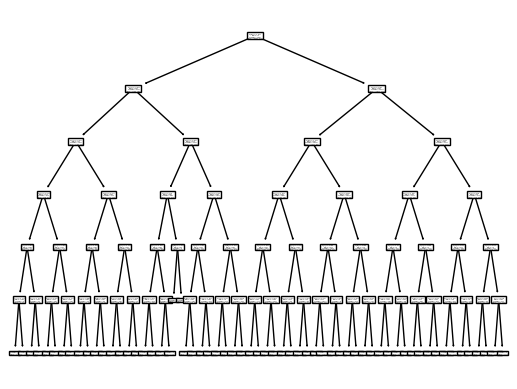

In [22]:
from sklearn.tree import plot_tree

plot_tree(optimal_model)
"""Simply too large to be useful visual"""

With the improvement on the dummy classifier exceeding 40% and 30% for the training and validation sets respectively, we can be confident that there exists tangible improvement to accuracy for customer conversion prediction. Our next step is to visualize the improvement in efficiency which the model could produce as a function of the population decile. This is the lift curve, which essentially quantifies the percentage improvement over the baseline of the modelling approach. As we can see, this model performs better than its raw accuracy might imply in predicting the rate of positive conversions(gain).

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

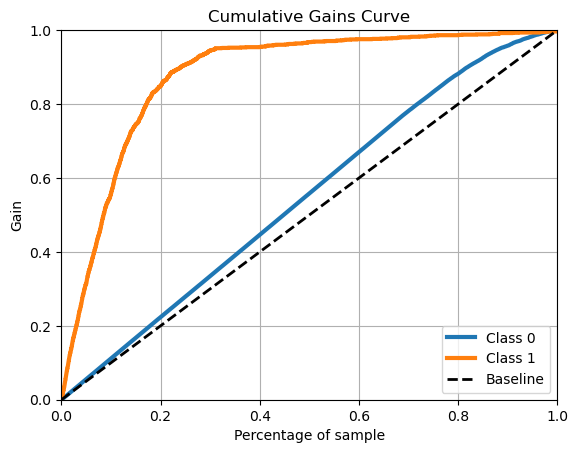

In [18]:
from scikitplot.metrics import plot_cumulative_gain

plot_cumulative_gain(y_test, optimal_model.predict_proba(X_test))

Lastly, we perform feature permutation to inspect the individual features importance to the model. We find that duration, nr.employed, month and euribor3m have the strongest impact on model decision-making. The first feature makes intuitive sense -- customers that stay on the line longer are more likely to be interested in purchasing the product. The economic indicators (nr.employed and euribor3m) are interesting as they have associated seasonality trends (i.e. month) which could indicate to a business when to spin up or down operations.

In [33]:
from sklearn.inspection import permutation_importance

r = permutation_importance(optimal_model, X_test, y_test, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         print(f"{tfm.get_feature_names_out()[i]:<8} "
         f"{r.importances_mean[i]:.3f}"
         f" +/- {r.importances_std[i]:.3f}")

# This code is nominally modified from the sklearn documentation for permutation_importance: https://scikit-learn.org/stable/modules/permutation_importance.html
# Credit for its phrasing must be given to the sci-kit learn developers (BSD license).

remainder__duration 0.048 +/- 0.001
remainder__nr.employed 0.037 +/- 0.002
remainder__month 0.027 +/- 0.001
remainder__euribor3m 0.021 +/- 0.001
remainder__pdays 0.007 +/- 0.000
onehotencoder__contact_telephone 0.001 +/- 0.001
remainder__campaign 0.001 +/- 0.000


This model can safely be employed with the expectation that the phone banking conversion rate will be improved by a factor of > 30%. This represents a concomitant efficiency improvement in worker hours ROI. The expanded dataset used to fit this model numbers 49 features --  a featurespace which is difficult to disentangle without this model. Thanks to the model, we now have the benefit of knowing that larger economic trends and seasonality have an effect on the efficiency of conversion.

Further improvements to this model could be made by comparing models of feature regularization as shown in the data understanding section. This would directly benefit the SVM fit time as shown in the average fit time in the modelling section. My intuition, drawing from the results of the attached paper, is that the SVM likely would have produced better results if its hyperparameters were better tuned. This was difficult to do at scale, however. 